In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import normal
from scipy.optimize import curve_fit

From _Numerical Recipes_, ch. 15.2:
$$
S = \sum_{i=0}^{N-1} \frac{1}{\sigma_i^2}, 
S_x = \sum_{i=0}^{N-1} \frac{x_i}{\sigma_i^2}, 
S_y = \sum_{i=0}^{N-1} \frac{y_i}{\sigma_i^2}, 
S_{xx} = \sum_{i=0}^{N-1} \frac{x_i^2}{\sigma_i^2}, 
S_{xy} = \sum_{i=0}^{N-1} \frac{x_i^2}{\sigma_i^2}
$$

$$
\Delta = S S_{xx} - \left( S_x \right)^2, 
a = \frac{S_{xx} S_y - S_x S_{xy}}{\Delta},
b = \frac{S S_{xy} - S_x S_y}{\Delta}
$$

$$
\sigma_a^2 = \frac{S_{xx}}{\Delta},
\sigma_b^2 = \frac{S}{\Delta}
$$

The velocity profile is given by
$$
u(z) = \frac{u_\star}{\kappa} \ln \left( \frac{z}{z_\star} \right)
$$
with $z_\star$ as the roughness scale (as opposed to the usual $z_0$).

Re-casting as a linear fit:$y_i = m x_i + b$ with $x_i = \ln \left( z_i / z_0 \right)$, $y_i = u(z_i)$, $m = u_\star/\kappa$, and $b = -\dfrac{u_\star}{\kappa} \ln \left( \dfrac{z_\star}{z_0} \right)$, where $z_0$ is the bottom anemometer height.

Assume logarithmic spacing, i.e. $\ln\left( z_i / z_0 \right) = i\ \delta x$.

$$
S = \dfrac{N}{\sigma^2}, S_x = \dfrac{\delta x}{\sigma^2} \left( \dfrac{(N-1) N}{2} \right), S_{xx} = \dfrac{\delta x^2}{\sigma^2} \left( \dfrac{\left( N - 1 \right) N \left( 2N - 1 \right)}{6} \right), \Delta = \dfrac{\delta x^2 N^2}{12 \sigma^4} \left( N^2 - 1 \right).
$$

Notes from 2022 May 8 work out these expresssions.

Square of the uncertainties for the slope and intercept:
$$
\sigma_m^2 = \left( \dfrac{2N \left( 2N - 1 \right)}{N^2 \left( N + 1 \right)} \right) \sigma^2, \sigma_b^2 = \left( \dfrac{12}{\delta x^2 N \left( N^2 - 1 \right) } \right) \sigma^2
$$

In [22]:
def calc_S(sigma):
    return np.sum(1./sigma**2)

def calc_Sx(x, sigma):
    return np.sum(x/sigma**2)

def calc_Sxx(x, sigma):
    return np.sum(x**2/sigma**2)

def calc_Sy(y, sigma):
    return np.sum(y/sigma**2)

def calc_Sxy(x, y, sigma):
    return np.sum(x*y/sigma**2)

def calc_Syy(y, sigma):
    return np.sum(y**2/sigma**2)

def calc_Delta(x, sigma):
    S = calc_S(sigma)
    Sxx = calc_Sxx(x, sigma)
    Sx = calc_Sx(x, sigma)
    
    return S*Sxx - Sx**2

def calc_intercept(x, y, sigma):
    Sxx = calc_Sxx(x, sigma)
    Sy = calc_Sy(y, sigma)
    Sx = calc_Sx(x, sigma)
    Sxy = calc_Sxy(x, y, sigma)
    Delta = calc_Delta(x, sigma)
    
    return (Sxx*Sy - Sx*Sxy)/Delta

def calc_slope(x, y, sigma):
    S = calc_S(sigma)
    Sxy = calc_Sxy(x, y, sigma)
    Sx = calc_Sx(x, sigma)
    Sy = calc_Sy(y, sigma)
    Delta = calc_Delta(x, sigma)
    
    return (S*Sxy - Sx*Sy)/Delta

def sigma_slope(x, sigma):
    Sxx = calc_Sxx(x, sigma)
    Delta = calc_Delta(x, sigma)
    
    return (Sxx/Delta)

def sigma_intercept(x, sigma):
    S = calc_S(sigma)
    Delta = calc_Delta(x, sigma)
    
    return (S/Delta)

In [88]:
def lin_fit(x, m, b):
    return m*x + b

def calc_unc_sq(sigma, delta_x, num_sensors):
    
    return 2*num_sensors*(2*num_sensors - 1)/(num_sensors**2*(num_sensors + 1))*sigma**2,\
        12./(delta_x**2*num_sensors*(num_sensors**2 - 1))*sigma**2

# Let's test these expressions
num_sensors = 5
delta_x = 2.
sigma = 1.
slope = 10.
intercept = 10.

x = np.arange(num_sensors)*delta_x
y = np.polyval([slope, intercept], x)
noisy_y = y + normal(scale=sigma, size=num_sensors)

print(calc_slope(x, noisy_y, sigma), calc_intercept(x, noisy_y, sigma), 
      sigma_slope(x, sigma), sigma_intercept(x, sigma))

# plt.plot(x, y)
# plt.plot(x, noisy_y, marker='o')

# popt, pcov = curve_fit(lin_fit, x, noisy_y, sigma=sigma*np.ones_like(x), p0=[slope, intercept])
# unc_sq = np.diag(pcov)
# print(popt)
# print(pcov)
# print(slope, intercept)
# print(calc_unc_sq(sigma, delta_x, num_sensors))

print(np.polyfit(x, noisy_y, 1, w=1./sigma*np.ones_like(x), full=True))

12.932546823096748 -7.316230567786676 -0.42857142857142855 -0.0035714285714285713
(array([10.0060546 , 10.24272279]), array([3.63412352]), 2, array([1.34777468, 0.42837299]), 1.1102230246251565e-15)


[3.5        2.17142857 2.10526316 3.25       2.34615385 2.29508197]


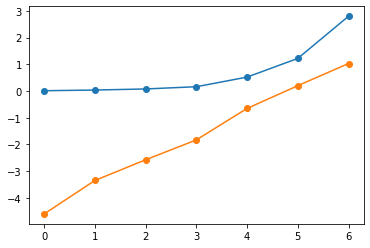

In [6]:
# z values from Pelletier & Field (2016)
zs = np.array([0.01, 0.035, 0.076, 0.16, 0.52, 1.22, 2.8]) # m
plt.plot(zs, marker='o')
plt.plot(np.log(zs), marker='o')

# Roughly logarithmic spacing
print(zs[1:]/zs[0:-1])